# Binary response: Alternative link functions

In this example we use a simple dataset to fit a Generalized Linear Model for a binary response using different link functions.

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.special import expit as invlogit
from scipy.stats import norm

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)

## Generalized linear models for binary response

First of all, let's review some concepts. A Generalized Linear Model (GLM) is made of three components.

**1. Random component**

A set of independent and identically distributed random variables $Y_i$. Their (conditional) probability distribution belongs to the same family $f$ with a mean given by $\mu_i$. 

**2. Systematic component (a.k.a linear predictor)**

Constructed by a linear combination of the parameters $\beta_j$ and explanatory variables $x_j$, represented by $\eta_i$

$$
\eta_i = \mathbf{x}_i^T\mathbf{\beta} = x_{i1}\beta_1 + x_{i2}\beta_2 + \cdots + x_{ip}\beta_p
$$

**3. Link function**

A monotone and differentiable function $g$ such that 

$$
g(\mu_i) = \eta_i = \mathbf{x}_i^T\mathbf{\beta}
$$
where $\mu_i = E(Y_i)$

As we can see, this function specifies the link between the random and the systematic components of the model.

An important feature of GLMs is that no matter we are modeling a function of $\mu$ (and not just $\mu$, unless $g$ is the identity function) is that we can show predictions in terms of the mean $\mu$ by using the inverse of $g$ on the linear predictor $\eta_i$

$$
g^{-1}(\eta_i) = g^{-1}(\mathbf{x}_i^T\mathbf{\beta}) = \mu_i
$$


In Bambi, we can use `family="bernoulli"` to tell we are modeling a binary variable that follows a Bernoulli distribution and our random component is of the form

$$
Y_i = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{with probability } \pi_i \\
        0 & \textrm{with probability } 1 - \pi_i 
    \end{array}
\right.
$$

that has a mean $\mu_i$ equal to the probability of success $\pi_i$.

By default, this family implies $g$ is the **logit function**.

$$
\begin{array}{lcr}    
    \displaystyle \text{logit}(\pi_i) = \log{\left( \frac{\pi_i}{1 - \pi_i} \right)} = \eta_i &
    \text{ with } &
    \displaystyle g^{-1}(\eta) = \frac{1}{1 + e^{-\eta}} = \pi_i
\end{array}
$$
    
But there are other options available, like the **probit** and the **cloglog** link functions.  

The **probit** function is the inverse of the cumulative density function of a standard Gaussian distribution 

$$
\begin{array}{lcr}    
    \displaystyle \text{probit}(\pi_i) = \Phi^{-1}(\pi_i) = \eta_i &
    \text{ with } &
    \displaystyle g^{-1}(\eta) = \Phi(\eta_i) = \pi_i
\end{array}
$$

And with the **cloglog** link function we have 

$$
\begin{array}{lcr}    
    \displaystyle \text{cloglog}(\pi_i) = \log(-\log(1 - \pi)) = \eta_i &
    \text{ with } &
    \displaystyle g^{-1}(\eta) = 1 - \exp(-\exp(\eta_i)) = \pi_i
\end{array}
$$

**cloglog** stands for **complementary log-log** and $g^{-1}$ is the cumulative density function of the extreme minimum value distribution.

Let's plot them to better understand the implications of what we're saying.

In [3]:
def invcloglog(x):
    return 1 - np.exp(-np.exp(x))

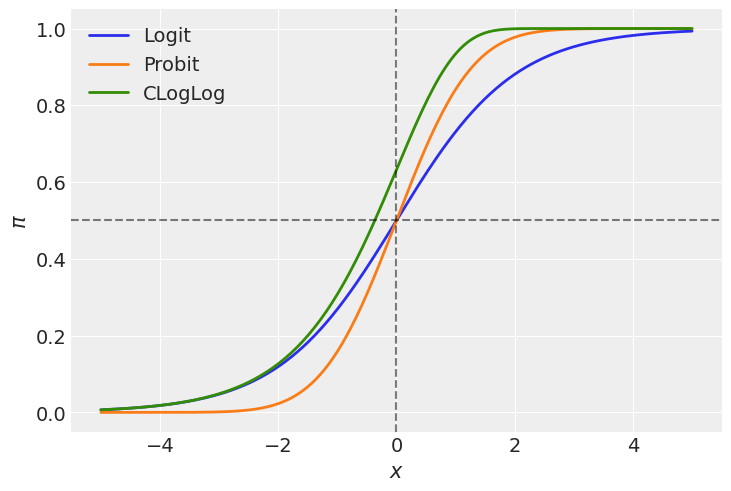

In [4]:
x = np.linspace(-5, 5, num=200)

# inverse of the logit function
logit = invlogit(x)

# cumulative density function of standard gaussian
probit = norm.cdf(x)

# inverse of the cloglog function
cloglog = invcloglog(x)

plt.plot(x, logit, color="C0", lw=2, label="Logit")
plt.plot(x, probit, color="C1", lw=2, label="Probit")
plt.plot(x, cloglog, color="C2", lw=2, label="CLogLog")
plt.axvline(0, c="k", alpha=0.5, ls="--")
plt.axhline(0.5, c="k", alpha=0.5, ls="--")
plt.xlabel(r"$x$")
plt.ylabel(r"$\pi$")
plt.legend();

In the plot above we can see both the **logit** and the **probit** links are symmetric in terms of their slopes at $-x$ and $x$. We can say the function approaches $\pi = 0.5$ at the same rate as it moves away from it. However, these two functions differ in their tails. The **probit** link approaches 0 and 1 faster than the **logit** link as we move away from $x=0$. Just see the orange line is below the blue one for $x < 0$ and it is above for $x > 0$. In other words, the logit function has heavier tails than the probit.

On the other hand, the **cloglog** does not present this symmetry, and we can clearly see it since the green line does not cross the point (0, 0.5). This function approaches faster the 1 than 0 as we move away from $x=0$.

## Load data

We use a data set consisting of the numbers of beetles dead after five hours of exposure to gaseous carbon disulphide at various concentrations. This data can be found in _An Introduction to Generalized Linear Models by A. J. Dobson and A. G. Barnett_, but the original source is (Bliss, 1935).

| Dose, $x_i$ <br />($\log_{10}\text{CS}_2\text{mgl}^{-1}$)| Number of beetles, $n_i$ | Number killed, $y_i$ |
| --- | --- | --- |
| 1.6907 | 59 | 6 |
| 1.7242 | 60 | 13 |
| 1.7552 | 62 | 18 |
| 1.7842 | 56 | 28 |
| 1.8113 | 63 | 52 |
| 1.8369 | 59 | 53 |
| 1.8610 | 62 | 61 |
| 1.8839 | 60 | 60 |

We create a data frame where the data is in long format (i.e. each row is an observation with a 0-1 outcome).

In [5]:
x = np.array([1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.8610, 1.8839])
n = np.array([59, 60, 62, 56, 63, 59, 62, 60])
y = np.array([6, 13, 18, 28, 52, 53, 61, 60])

data = pd.DataFrame({"x": x, "n": n, "y": y})

## Build the models

Bambi has two families to model binary data: Bernoulli and Binomial. The first one can be used when each row represents a single observation with a column containing the binary outcome, while the second is used when each row represents a group of observations or realizations and there's one column for the number of successes and another column for the number of trials. 

Since we have aggregated data, we're going to use the Binomial family. This family requires using the function `proportion(y, n)` on the left side of the model formula to indicate we want to model the proportion between two variables. This function can be replaced by any of its aliases `prop(y, n)` or `p(y, n)`. Let's use the shortest one here.

In [6]:
formula = "p(y, n) ~ x"


### Logit link

The logit link is the default link when we say `family="binomial"`, so there's no need to add it.

In [7]:
model_logit = bmb.Model(formula, data, family="binomial")
idata_logit = model_logit.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


### Probit link

In [8]:
model_probit = bmb.Model(formula, data, family="binomial", link="probit")
idata_probit = model_probit.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


### Cloglog link

In [9]:
model_cloglog = bmb.Model(formula, data, family="binomial", link="cloglog")
idata_cloglog = model_cloglog.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


## Results

We can use the samples from the posteriors to see the mean estimate for the probability of dying at each concentration level. To do so, we use a little helper function that will help us to write less code. This function leverages the power of the new `Model.predict()` method that is helpful to obtain both in-sample and out-of-sample predictions.

In [10]:
def get_predictions(model, idata, seq):
    # Create a data frame with the new data
    new_data = pd.DataFrame({"x": seq})
    
    # Predict probability of dying using out of sample data
    model.predict(idata, data=new_data)
    
    # Get posterior mean across chains and draws
    mu = idata.posterior["p(y, n)_mean"].values.mean((0, 1))
    return mu

In [11]:
x_seq = np.linspace(1.6, 2, num=200)

mu_logit = get_predictions(model_logit, idata_logit, x_seq)
mu_probit = get_predictions(model_probit, idata_probit, x_seq)
mu_cloglog = get_predictions(model_cloglog, idata_cloglog, x_seq)

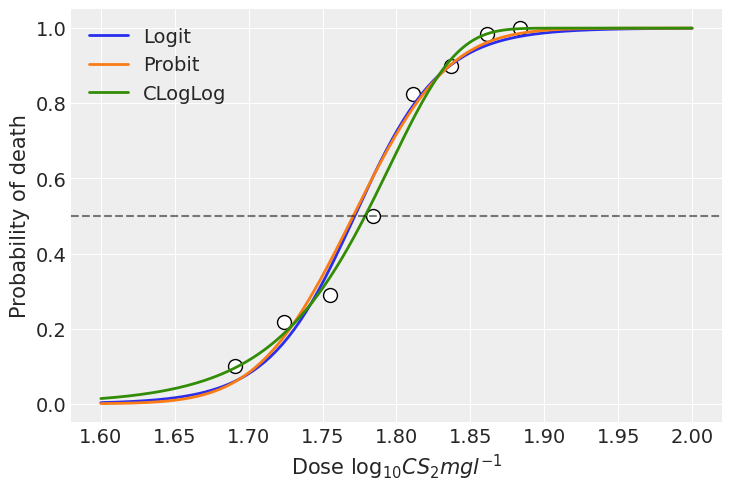

In [12]:
plt.scatter(x, y / n, c = "white", edgecolors = "black", s=100)
plt.plot(x_seq, mu_logit, lw=2, label="Logit")
plt.plot(x_seq, mu_probit, lw=2, label="Probit")
plt.plot(x_seq, mu_cloglog, lw=2, label="CLogLog")
plt.axhline(0.5, c="k", alpha=0.5, ls="--")
plt.xlabel(r"Dose $\log_{10}CS_2mgl^{-1}$")
plt.ylabel("Probability of death")
plt.legend();

In this example, we can see the models using the **logit** and **probit** link functions present very similar estimations. With this particular data, all the three link functions fit the data well and the results do not differ significantly. However, there can be scenarios where the results are more sensitive to the choice of the link function.

**References**

Bliss, C. I. (1935). The calculation of the dose-mortality curve. Annals of Applied Biology 22, 134–167

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Aug 09 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

matplotlib: 3.3.3
bambi     : 0.5.0
arviz     : 0.11.2
numpy     : 1.21.1
pandas    : 1.3.1
json      : 2.0.9

Watermark: 2.1.0

